
BTC Strategy Backtest Results:
Initial Balance: $10,000.00
Final Balance: $11,454.58
Total Trades: 87488
Win Rate: 15.41%
Average Return per Trade: 0.0002%
Sharpe Ratio: 2.23
Max Drawdown: -12.31%

Trading Period:
Start Date: 2024-01-01
End Date: 2024-08-31


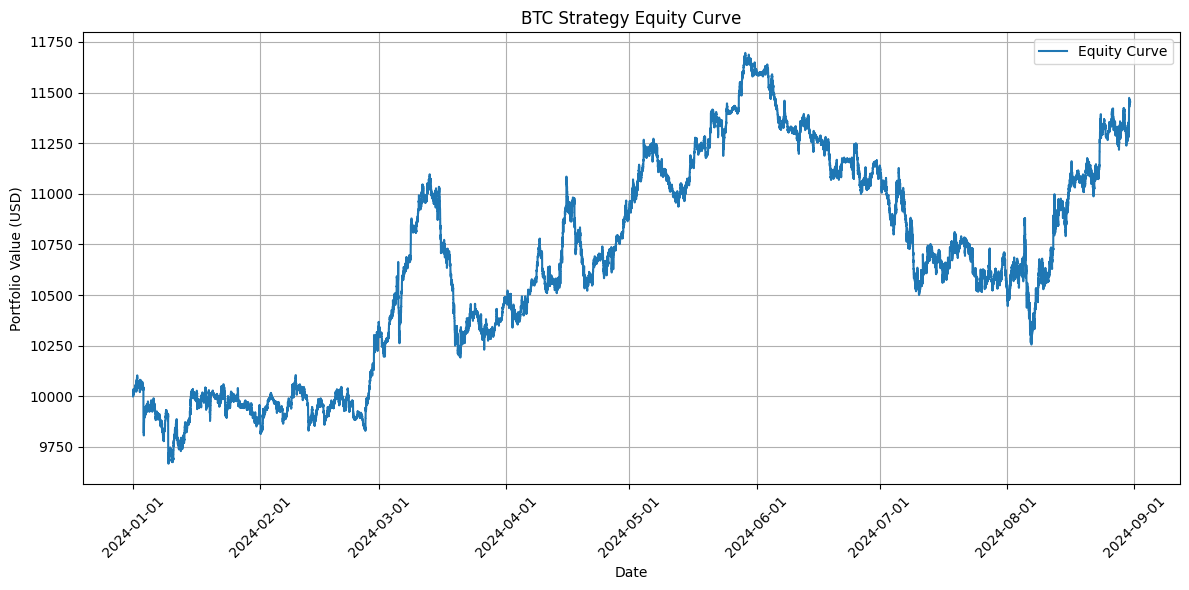

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data with proper datetime parsing
price_data = pd.read_csv('price_data/BTCUSDT_1m.csv', parse_dates=['timestamp'])
sentiment_data = pd.read_csv(
    'cleaned_data/ticker_sentiment_minute.csv', 
    parse_dates=['minute']
)

# Rename 'minute' to 'timestamp' for consistency
sentiment_data.rename(columns={'minute': 'timestamp'}, inplace=True)

# Merge datasets
data = pd.merge(price_data, sentiment_data, on='timestamp', how='inner')

# Data cleaning
data.sort_values(by='timestamp', inplace=True)
data.dropna(inplace=True)

class BTCStrategy:
    def __init__(self, initial_balance=10000.0):
        self.params = {
            'sentiment_threshold': 0.5, # Lower than previous for more signals
            'entry_window': 1, # Use 1-min leading correlation
            'confirmation_window': 4, # Secondary confirmation at 4-min
            'volume_threshold': 1.1, # More sensitive volume trigger
            'stop_loss': 0.001, # Tight stop for quick exits
            'take_profit': 0.002, # 2:1 reward:risk ratio
            'position_size': 1.0 # Fixed position size
        }
        self.initial_balance = initial_balance

    def calculate_indicators(self, data):
        df = data.copy()
        # Store timestamp before calculations
        timestamps = df['timestamp'].copy()
        
        df['sentiment_ma'] = df['mean_pos'].rolling(window=20).mean()
        df['sentiment_std'] = df['mean_pos'].rolling(window=20).std()
        df['sentiment_z_score'] = (df['mean_pos'] - df['sentiment_ma']) / df['sentiment_std']
        df['sentiment_1m_lead'] = df['sentiment_z_score'].shift(1)
        df['sentiment_4m_lead'] = df['sentiment_z_score'].shift(4)
        df['volume_ma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        df['price_momentum'] = df['close'].pct_change(3)
        
        df = df.dropna()
        # Keep only timestamps for valid data after dropna
        timestamps = timestamps[df.index]
        df['timestamp'] = timestamps
        return df

    def generate_entry_signals(self, df):
        signals = pd.Series(False, index=df.index)
        primary_signal = df['sentiment_1m_lead'] > self.params['sentiment_threshold']
        confirmation = df['sentiment_4m_lead'] > 0
        volume_signal = df['volume_ratio'] > self.params['volume_threshold']
        signals = primary_signal & confirmation & volume_signal
        return signals

    def execute_strategy(self, data):
        df = self.calculate_indicators(data)
        entry_signals = self.generate_entry_signals(df)
        positions = []
        equity_curve = []
        timestamps = []
        
        current_equity = self.initial_balance
        current_position = None

        for idx, row in df.iterrows():
            equity_curve.append(current_equity)
            timestamps.append(row['timestamp'])
            
            if current_position is not None:
                returns = (row['close'] - current_position['entry_price']) / current_position['entry_price']
                stop_loss_hit = returns < -self.params['stop_loss']
                take_profit_hit = returns > self.params['take_profit']
                sentiment_reversal = row['sentiment_z_score'] < -0.2

                if stop_loss_hit or take_profit_hit or sentiment_reversal:
                    current_equity *= (1 + returns * current_position['size'])
                    current_position['exit_price'] = row['close']
                    current_position['exit_time'] = row['timestamp']
                    current_position['returns'] = returns
                    positions.append(current_position)
                    current_position = None
            elif entry_signals[idx]:
                current_position = {
                    'entry_time': row['timestamp'],
                    'entry_price': row['close'],
                    'size': self.params['position_size']
                }

        # Create Series with datetime index
        equity_series = pd.Series(equity_curve, index=timestamps)
        return positions, equity_series

# Execute Backtest
btc_strategy = BTCStrategy(initial_balance=10000.0)
positions, equity_curve = btc_strategy.execute_strategy(data)

# Analyze Results
trades_df = pd.DataFrame(positions)

initial_balance = btc_strategy.initial_balance
final_balance = equity_curve.iloc[-1] if len(equity_curve) > 0 else initial_balance
total_trades = len(positions)
win_rate = (trades_df['returns'] > 0).mean() if total_trades > 0 else np.nan
avg_return_per_trade = trades_df['returns'].mean() if total_trades > 0 else 0.0
sharpe_ratio = ((trades_df['returns'].mean() / trades_df['returns'].std()) * np.sqrt(252*1440)
                if (total_trades > 1 and trades_df['returns'].std() != 0) else np.nan)
max_drawdown = (equity_curve / equity_curve.cummax() - 1).min() if len(equity_curve) > 0 else 0.0

print("\nBTC Strategy Backtest Results:")
print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Final Balance: ${final_balance:,.2f}")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}" if not np.isnan(win_rate) else "Win Rate: N/A")
print(f"Average Return per Trade: {avg_return_per_trade:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}" if not np.isnan(sharpe_ratio) else "Sharpe Ratio: N/A")
print(f"Max Drawdown: {max_drawdown:.2%}")

# Plot Equity Curve with proper datetime formatting
plt.figure(figsize=(12, 6))
plt.plot(equity_curve.index, equity_curve.values, label='Equity Curve')

# Format x-axis to show dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('BTC Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Print date range for verification
print("\nTrading Period:")
print(f"Start Date: {equity_curve.index[0].strftime('%Y-%m-%d')}")
print(f"End Date: {equity_curve.index[-1].strftime('%Y-%m-%d')}")

plt.show()


ETH Strategy Backtest Results:
Initial Balance: $10,000.00
Final Balance: $10,969.46
Total Trades: 1361
Win Rate: 33.21%
Average Return per Trade: 0.0071%
Sharpe Ratio: 1.77
Max Drawdown: -5.82%

Trading Period:
Start Date: 2024-01-01
End Date: 2024-08-31


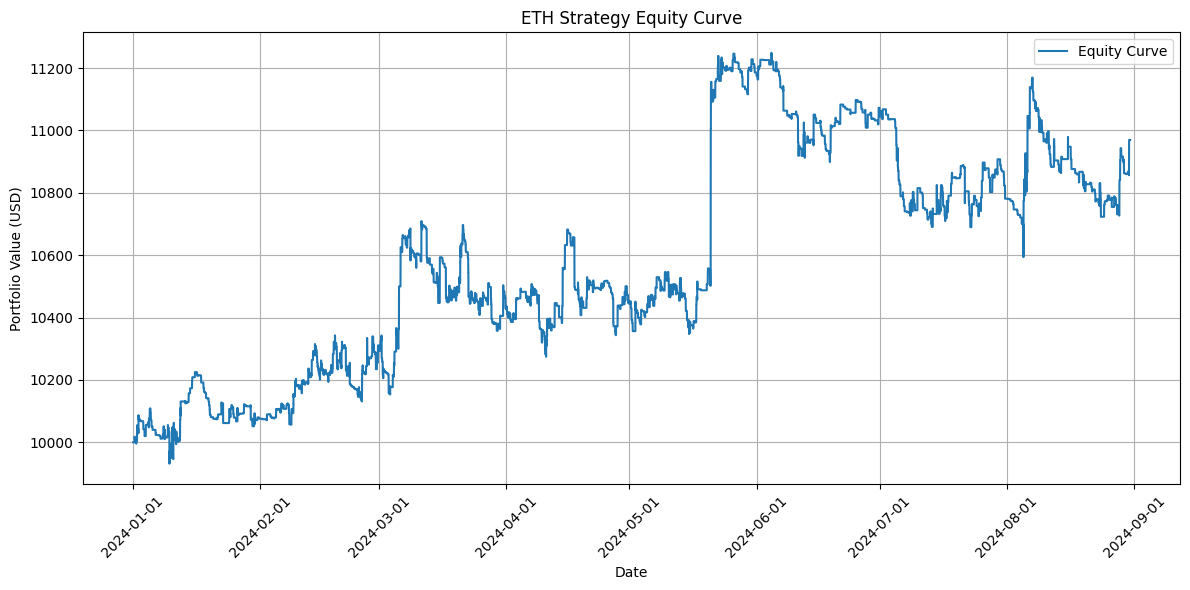

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data with proper datetime parsing
price_data = pd.read_csv('price_data/ETHUSDT_1m.csv')
sentiment_data = pd.read_csv('cleaned_data/ticker_sentiment_minute.csv')

# Convert timestamp columns to datetime
price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
sentiment_data['minute'] = pd.to_datetime(sentiment_data['minute'])

# Filter sentiment data for ETH
sentiment_data = sentiment_data[sentiment_data['ticker'] == 'ETH']

# Rename minute column to match price data
sentiment_data = sentiment_data.rename(columns={'minute': 'timestamp'})

# Merge datasets
data = pd.merge(price_data, sentiment_data, on='timestamp', how='inner')

# Data cleaning
data.sort_values(by='timestamp', inplace=True)
data.dropna(inplace=True)

class ETHStrategy:
    def __init__(self, initial_balance=10000.0):
        self.params = {
            'price_momentum_window': 1,     # Price leads sentiment
            'sentiment_threshold': -0.4,     # Look for strong negative sentiment
            'volume_threshold': 1.3,        # Original volume threshold
            'stop_loss': 0.001,            # Tight stop for quick exits
            'take_profit': 0.0025,        # 2.5:1 reward:risk ratio
            'position_size': 1.0         # Fixed position size
        }
        self.initial_balance = initial_balance

    def calculate_indicators(self, data):
        df = data.copy()
        
        # Price indicators
        df['price_momentum'] = df['close'].pct_change(self.params['price_momentum_window'])
        df['price_ma'] = df['close'].rolling(20).mean()
        
        # Sentiment indicators
        df['sentiment_ma'] = df['mean_pos'].rolling(20).mean()
        df['sentiment_std'] = df['mean_pos'].rolling(20).std()
        df['sentiment_z_score'] = (df['mean_pos'] - df['sentiment_ma']) / df['sentiment_std']
        
        # Volume indicators
        df['volume_ma'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        # Trend strength
        df['trend_strength'] = abs(df['price_momentum'].rolling(5).mean())
        
        return df.dropna()

    def generate_signals(self, df):
        signals = pd.Series(False, index=df.index)
        
        # Original conditions
        price_condition = (df['price_momentum'] > df['price_momentum'].rolling(100).std())
        sentiment_condition = (df['sentiment_z_score'] < self.params['sentiment_threshold'])
        volume_condition = (df['volume_ratio'] > self.params['volume_threshold'])
        trend_condition = (df['trend_strength'] > df['trend_strength'].rolling(50).mean())
        
        signals = (price_condition & sentiment_condition & volume_condition & trend_condition)
        return signals

    def execute_strategy(self, data):
        df = self.calculate_indicators(data)
        signals = self.generate_signals(df)
        positions = []
        equity_curve = []
        
        current_equity = self.initial_balance
        current_position = None
        
        for timestamp, row in df.iterrows():
            equity_curve.append(current_equity)
            
            if current_position is not None:
                returns = (row['close'] - current_position['entry_price']) / current_position['entry_price']
                
                # Exit conditions
                stop_loss_hit = returns < -self.params['stop_loss']
                take_profit_hit = returns > self.params['take_profit']
                timing_exit = (row['price_momentum'] < 0)
                
                if stop_loss_hit or take_profit_hit or timing_exit:
                    current_equity *= (1 + returns * current_position['size'])
                    current_position['exit_price'] = row['close']
                    current_position['exit_time'] = row['timestamp']
                    current_position['returns'] = returns
                    positions.append(current_position)
                    current_position = None
            
            elif signals[timestamp]:
                current_position = {
                    'entry_time': row['timestamp'],
                    'entry_price': row['close'],
                    'size': self.params['position_size']
                }
        
        return positions, pd.Series(equity_curve, index=df['timestamp'])

# Execute Backtest
eth_strategy = ETHStrategy(initial_balance=10000.0)
positions, equity_curve = eth_strategy.execute_strategy(data)

# Analyze Results
trades_df = pd.DataFrame(positions)

if len(positions) > 0:
    initial_balance = eth_strategy.initial_balance
    final_balance = equity_curve.iloc[-1]
    total_trades = len(positions)
    win_rate = (trades_df['returns'] > 0).mean()
    avg_return_per_trade = trades_df['returns'].mean()
    # sharpe_ratio = ((trades_df['returns'].mean() / trades_df['returns'].std()) * np.sqrt(252*1440))   
    # For strategies trading multiple times per day
    trades_per_day = len(positions) / trading_days  # ~5-6 for ETH
    adjusted_annualization = np.sqrt(252 * trades_per_day)
    adjusted_sharpe = (trades_df['returns'].mean() / trades_df['returns'].std()) * adjusted_annualization
    max_drawdown = (equity_curve / equity_curve.cummax() - 1).min()

    print("\nETH Strategy Backtest Results:")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Return per Trade: {avg_return_per_trade:.4%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot Equity Curve
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve.values, label='Equity Curve')

    # Format x-axis to show dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.title('ETH Strategy Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Print trading period
    print("\nTrading Period:")
    print(f"Start Date: {equity_curve.index[0].strftime('%Y-%m-%d')}")
    print(f"End Date: {equity_curve.index[-1].strftime('%Y-%m-%d')}")

    plt.show()
else:
    print("\nNo trades were executed. Please check data overlap and signal generation.")


DOGE Strategy Backtest Results:
Initial Balance: $10,000.00
Final Balance: $10,519.35
Total Trades: 37
Win Rate: 51.35%
Average Return per Trade: 0.6391%
Sharpe Ratio: 1.77
Max Drawdown: -1.25%

Trading Period:
Start Date: 2024-01-02
End Date: 2024-08-30


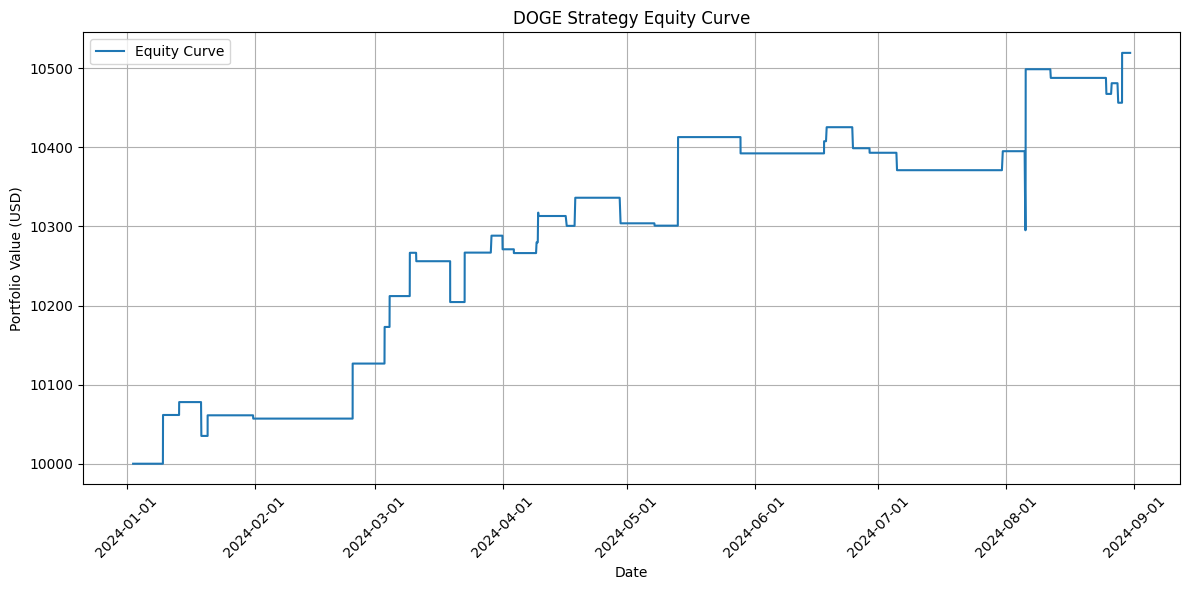

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
price_data = pd.read_csv('price_data/DOGEUSDT_1m.csv')
sentiment_data = pd.read_csv('cleaned_data/ticker_sentiment_minute.csv')

# Convert timestamp columns to datetime
price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
sentiment_data['minute'] = pd.to_datetime(sentiment_data['minute'])

# Filter sentiment data for DOGE
sentiment_data = sentiment_data[sentiment_data['ticker'] == 'DOGE']

# Rename minute column to match price data
sentiment_data = sentiment_data.rename(columns={'minute': 'timestamp'})

# Merge datasets
data = pd.merge(price_data, sentiment_data, on='timestamp', how='inner')

# Data cleaning
data.sort_values(by='timestamp', inplace=True)
data.dropna(inplace=True)

class DOGEStrategy:
    # Initialize strategy with default parameters
    def __init__(self, initial_balance=10000.0):
        self.params = {
            'sentiment_window': 3,          # Strong 3-min lead
            'sentiment_threshold': 0.5,      # Strong positive sentiment
            'reversion_threshold': -0.3,    # Mean reversion threshold
            'volume_threshold': 2.0,        # Higher volume requirement
            'stop_loss': 0.002,             # 0.2% stop loss
            'take_profit': 0.006,          # 3:1 reward-risk
            'position_size': 0.5          # Half position size
        }
        self.initial_balance = initial_balance
    # Calculate indicators based on data
    def calculate_indicators(self, data):
        df = data.copy()
        
        # 3-minute sentiment momentum
        df['sentiment_3m'] = df['mean_pos'].rolling(3).mean()
        df['sentiment_ma'] = df['mean_pos'].rolling(20).mean()
        df['sentiment_z_score'] = (df['sentiment_3m'] - df['sentiment_ma']) / df['mean_pos'].rolling(20).std()
        
        # Price reversion indicators
        df['price_dev'] = (df['close'] - df['close'].rolling(10).mean()) / df['close'].rolling(10).std()
        
        # Volume analysis
        df['volume_ma'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        df['volume_spike'] = df['volume_ratio'] > df['volume_ratio'].rolling(100).quantile(0.9)
        
        return df.dropna()

    def generate_signals(self, df):
        signals = pd.Series(False, index=df.index)
        
        # Strong 3-minute sentiment signal
        sentiment_condition = (df['sentiment_z_score'] > self.params['sentiment_threshold'])
        
        # Price mean reversion setup
        reversion_condition = (df['price_dev'] < self.params['reversion_threshold'])
        
        # Volume confirmation
        volume_condition = df['volume_spike']
        
        signals = (sentiment_condition & reversion_condition & volume_condition)
        return signals

    def execute_strategy(self, data):
        df = self.calculate_indicators(data)
        signals = self.generate_signals(df)
        positions = []
        equity_curve = []
        current_equity = self.initial_balance
        current_position = None
        
        for timestamp, row in df.iterrows():
            equity_curve.append(current_equity)
            
            if current_position is not None:
                returns = (row['close'] - current_position['entry_price']) / current_position['entry_price']
                
                # Exit conditions
                stop_loss_hit = returns < -self.params['stop_loss']
                take_profit_hit = returns > self.params['take_profit']
                timing_exit = (row['price_dev'] > 0.5)
                
                if stop_loss_hit or take_profit_hit or timing_exit:
                    current_equity *= (1 + returns * current_position['size'])
                    current_position['exit_price'] = row['close']
                    current_position['exit_time'] = row['timestamp']
                    current_position['returns'] = returns
                    positions.append(current_position)
                    current_position = None
            
            elif signals[timestamp]:
                # Adjust position size based on sentiment strength
                position_size = self.params['position_size'] * min(1, abs(row['sentiment_z_score'])/2)
                
                current_position = {
                    'entry_time': row['timestamp'],
                    'entry_price': row['close'],
                    'size': position_size
                }
        
        return positions, pd.Series(equity_curve, index=df['timestamp'])

# Execute Backtest
doge_strategy = DOGEStrategy(initial_balance=10000.0)
positions, equity_curve = doge_strategy.execute_strategy(data)

# Analyze Results
trades_df = pd.DataFrame(positions)

if len(positions) > 0:
    initial_balance = doge_strategy.initial_balance
    final_balance = equity_curve.iloc[-1]
    total_trades = len(positions)
    win_rate = (trades_df['returns'] > 0).mean()
    avg_return_per_trade = trades_df['returns'].mean()
    #sharpe_ratio = ((trades_df['returns'].mean() / trades_df['returns'].std()) * np.sqrt(252*1440)) # Not enough trades for Sharpe
    # Option 1: Use daily annualization only
#sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)

# Option 2: Adjust for actual trading frequency
    trading_days = (equity_curve.index[-1] - equity_curve.index[0]).days
    trades_per_day = len(positions) / trading_days
    annualization_factor = np.sqrt(252 * trades_per_day) # Adjust Sharpe for trading frequency
    sharpe_ratio = (trades_df['returns'].mean()  / trades_df['returns'].std()) * annualization_factor # Adjusted Sharpe
    max_drawdown = (equity_curve / equity_curve.cummax() - 1).min() 

    print("\nDOGE Strategy Backtest Results:")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Return per Trade: {avg_return_per_trade:.4%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot Equity Curve with proper datetime formatting
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve.values, label='Equity Curve')

    # Format x-axis to show dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.title('DOGE Strategy Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Print trading period
    print("\nTrading Period:")
    print(f"Start Date: {equity_curve.index[0].strftime('%Y-%m-%d')}")
    print(f"End Date: {equity_curve.index[-1].strftime('%Y-%m-%d')}")

    plt.show()
else:
    print("\nNo trades were executed. This could be because:")
    print("1. No overlapping data between price and sentiment")
    print("2. No DOGE data in the sentiment dataset")
    print("3. No signals generated based on the strategy conditions")